# Correlation analysis
Explore the relationships between core and accessory genes

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from core_acc_modules import utils, paths

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in data (grouped by reference used)
gene_expression_ref_pao1 = pd.read_csv(paths.PAO1_GE, sep="\t", header=0, index_col=0)
gene_expression_ref_pa14 = pd.read_csv(paths.PA14_GE, sep="\t", header=0, index_col=0)

In [35]:
print(gene_expression_ref_pao1.shape)
print(gene_expression_ref_pa14.shape)

(28, 5685)
(28, 5959)


## Get shuffled dataset
The real gene expression data is shuffled along the genes in order to disrupt any existing relationship between genes. This will serve as a negative control when examining the relationship between genes later.

In [3]:
# Shuffled gene expression datasets
shuffled_all_ref_pao1 = utils.permute_expression_data(gene_expression_ref_pao1)
shuffled_all_ref_pa14 = utils.permute_expression_data(gene_expression_ref_pa14)

## Get core and accessory genes

Definition of core and accessory genes:

**Core genes** = genes homologous between PAO1 and PA14. **PAO1 core genes** are PAO1 reference genes that have a PA14 homolog found. Similarly, **PA14 core genes** are PA14 refrence genes that have a PAO1 homolog.

**PAO1 accessory** = All PAO1 genes - PAO1 core genes (PAO1-specific genes)

**PA14 accessory** = All PA14 genes - PA14 core genes (PA14-specific genes)

The annotations for what genes are homoglous between PAO1 and PA14 were obtained from [BACTOME website](https://pseudomonas-annotator.shinyapps.io/pa_annotator/)

In [4]:
# Get mapping between PAO1 and PA14 genes using PAO1 reference
gene_annot_file = paths.GENE_PAO1_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(gene_annot_file, 'pao1')
core_pao1_genes = utils.get_core_genes(gene_mapping_pao1)
print(f"Number of PAO1 core genes: {len(core_pao1_genes)}")

Number of PAO1 core genes: 5363


In [5]:
# Get PAO1-specific genes
pao1_ref_genes = gene_expression_ref_pao1.columns
pao1_acc = list(set(pao1_ref_genes) - set(core_pao1_genes))
print(f"Number of PAO1-specific genes: {len(pao1_acc)}")

Number of PAO1-specific genes: 322


In [23]:
# Get mapping between PAO1 and PA14 genes using PA14 reference 
gene_annot_file = paths.GENE_PA14_ANNOT
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(gene_annot_file, 'pa14')
core_pa14_genes = utils.get_core_genes(gene_mapping_pa14)
print(f"Number of PA14 core genes: {len(core_pa14_genes)}")

Number of PA14 core genes: 5362


In [7]:
# Get PA14-specific genes
pa14_ref_genes = gene_expression_ref_pa14.columns
pa14_acc = list(set(pa14_ref_genes) - set(core_pa14_genes))
print(f"Number of PA14-specific genes: {len(pa14_acc)}")

Number of PA14-specific genes: 597


### Compare core genes found
Are they the same genes? Which set of core genes should we use?

In [8]:
"""# Look at the difference between the sets of core genes using pao1 and pa14 references
mapped_pao1_core_genes = list(gene_mapping_pa14.loc[core_pa14_genes,'PAO1_gene_id'])

# Get list of shared core genes
shared_core_genes = list(set(core_pao1_genes).intersection(mapped_pao1_core_genes))
shared_core_genes_df = pd.DataFrame(shared_core_genes, columns=["shared core"])

# Get list of unique PAO1 core genes
pao1_unique_core_genes = list(set(core_pao1_genes) - set(mapped_pao1_core_genes))
pao1_unique_core_genes_df = pd.DataFrame(pao1_unique_core_genes, columns=["pao1 only core"])

# Get list of unique PA14 core genes
mapped_shared_core_genes = gene_mapping_pao1.loc[shared_core_genes,'PA14_gene_id']
pa14_unique_core_genes = list(set(core_pa14_genes)- set(mapped_shared_core_genes))
pa14_unique_core_genes_df = pd.DataFrame(pa14_unique_core_genes, columns=["pa14 only core"])

# Save lists to review with collaborators
shared_core_genes_df.to_csv(paths.SHARED_CORE, sep='\t')
pao1_unique_core_df.to_csv(paths.PAO1_CORE, sep='\t')
expression_pa14_df.to_csv(paths.PA14_CORE, sep='\t')

print(f'Number of PA14 and PAO1 core genes that overlap are {len(shared_core_genes)}')
print(f'Number of PAO1 unique core genes : {len(pao1_unique_core_genes)}')
print(f'Number of PA14 unique core genes : {len(pa14_unique_core_genes)}')"""

4778
Number of PA14 and PAO1 core genes that overlap are 4778
Number of PAO1 unique core genes : 585
Number of PA14 unique core genes : 585


Looks like there are 2 distinct core sets

## Group samples by genotype

In [10]:
# Group samples as PAO1 or PA14 based on experiment metadata
sample_annot_file = paths.SAMPLE_ANNOT

pao1_ids, pa14_ids = utils.get_sample_grps(sample_annot_file)

In [11]:
# PAO1 samples aligned to PAO1 reference
data_core_pao1_samples_pao1_ref = gene_expression_ref_pao1.loc[pao1_ids, core_pao1_genes]
data_acc_pao1_samples_pao1_ref = gene_expression_ref_pao1.loc[pao1_ids, pao1_acc]
print(data_core_pao1_samples_pao1_ref.shape)
print(data_acc_pao1_samples_pao1_ref.shape)

(13, 5363)
(13, 322)


In [12]:
# PA14 samples aligned to PA14 reference
data_core_pa14_samples_pa14_ref = gene_expression_ref_pa14.loc[pa14_ids, core_pa14_genes]
data_acc_pa14_samples_pa14_ref = gene_expression_ref_pa14.loc[pa14_ids, pa14_acc]
print(data_core_pa14_samples_pa14_ref.shape)
print(data_acc_pa14_samples_pa14_ref.shape)

(15, 5362)
(15, 597)


In [13]:
# PA14 samples aligned to PAO1 reference
data_core_pa14_samples_pao1_ref = gene_expression_ref_pao1.loc[pa14_ids, core_pao1_genes]
data_acc_pa14_samples_pao1_ref = gene_expression_ref_pao1.loc[pa14_ids, pao1_acc]
print(data_core_pa14_samples_pao1_ref.shape)
print(data_acc_pa14_samples_pao1_ref.shape)

(15, 5363)
(15, 322)


In [14]:
# PAO1 samples aligned to PA14 reference
data_core_pao1_samples_pa14_ref = gene_expression_ref_pa14.loc[pao1_ids, core_pa14_genes]
data_acc_pao1_samples_pa14_ref = gene_expression_ref_pa14.loc[pao1_ids, pa14_acc]
print(data_core_pao1_samples_pa14_ref.shape)
print(data_acc_pao1_samples_pa14_ref.shape)

(13, 5362)
(13, 597)


## Distribution of gene expression
Examine the distribution of mean gene expression for core and accessory genes in each of these 4 groups of samples (total of 8 plots)

In [24]:
# Examine PAO1 samples in PAO1 reference
pao1_samples_pao1_ref_core = gene_expression_ref_pao1.loc[pao1_ids,core_pao1_genes].mean()
pao1_samples_pao1_ref_acc = gene_expression_ref_pao1.loc[pao1_ids,pao1_acc].mean()

# Examine PA14 samples in PAO1 reference
pa14_samples_pao1_ref_core = gene_expression_ref_pao1.loc[pa14_ids,core_pao1_genes].mean()
pa14_samples_pao1_ref_acc = gene_expression_ref_pao1.loc[pa14_ids,pao1_acc].mean()

# Examine PAO1 samples in PA14 reference
pao1_samples_pa14_ref_core = gene_expression_ref_pa14.loc[pao1_ids,core_pa14_genes].mean()
pao1_samples_pa14_ref_acc = gene_expression_ref_pa14.loc[pao1_ids,pa14_acc].mean()

# Examine PA14 samples in PA14 reference
pa14_samples_pa14_ref_core = gene_expression_ref_pa14.loc[pa14_ids,core_pa14_genes].mean()
pa14_samples_pa14_ref_acc = gene_expression_ref_pa14.loc[pa14_ids,pa14_acc].mean()

In [34]:
gene_expression_ref_pao1.loc[pao1_ids,core_pao1_genes].shape

(13, 5363)

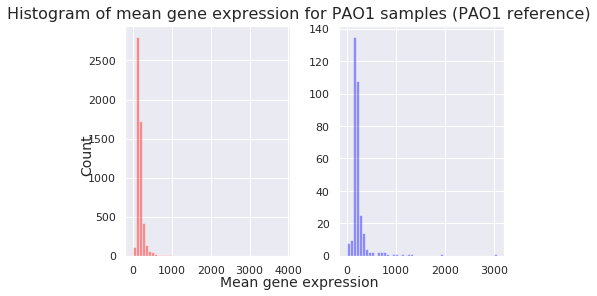

In [29]:
# Plot
sns.set()

# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

# Distribution plot for core genes
sns.distplot(pao1_samples_pao1_ref_core.values, 
             label='PAO1 samples PAO1 core genes', 
             color='red',
             kde=False,
             ax=axes[0]
            )

sns.distplot(pao1_samples_pao1_ref_acc.values,
             label='PAO1 samples PAO1 accessory genes',
             color='blue',
             kde=False,
             ax=axes[1]
            )

fig.xlim=(0,10)
plt.suptitle('Histogram of mean gene expression for PAO1 samples (PAO1 reference)',
            fontsize=16)
fig.text(0.5, 0.01, 'Mean gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)
plt.tight_layout(pad=0.4, 
                 w_pad=0.5,
                 h_pad=1.0,
                 rect=[0, 0.03, 1, 0.95])

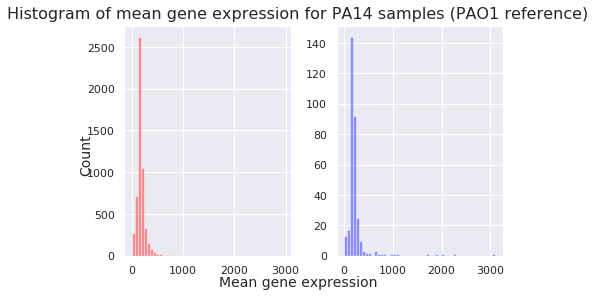

In [30]:
# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

# Distribution plot for core genes
sns.distplot(pa14_samples_pao1_ref_core.values, 
             label='PA14 samples PAO1 core genes', 
             color='red',
             kde=False,
             ax=axes[0]
            )

sns.distplot(pa14_samples_pao1_ref_acc.values,
             label='PA14 samples PAO1 accessory genes',
             color='blue',
             kde=False,
             ax=axes[1]
            )

fig.xlim=(0,10)
plt.suptitle('Histogram of mean gene expression for PA14 samples (PAO1 reference)',
            fontsize=16)
fig.text(0.5, 0.01, 'Mean gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)
plt.tight_layout(pad=0.4, 
                 w_pad=0.5,
                 h_pad=1.0,
                 rect=[0, 0.03, 1, 0.95])

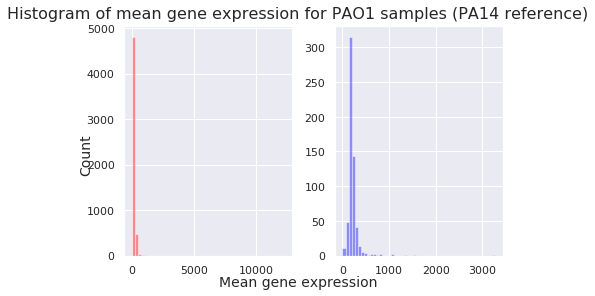

In [31]:
# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

# Distribution plot for core genes
sns.distplot(pao1_samples_pa14_ref_core.values, 
             label='PAO1 samples PA14 core genes', 
             color='red',
             kde=False,
             ax=axes[0]
            )

sns.distplot(pao1_samples_pa14_ref_acc.values,
             label='PAO1 samples PA14 accessory genes',
             color='blue',
             kde=False,
             ax=axes[1]
            )

fig.xlim=(0,10)
plt.suptitle('Histogram of mean gene expression for PAO1 samples (PA14 reference)',
            fontsize=16)
fig.text(0.5, 0.01, 'Mean gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)
plt.tight_layout(pad=0.4, 
                 w_pad=0.5,
                 h_pad=1.0,
                 rect=[0, 0.03, 1, 0.95])

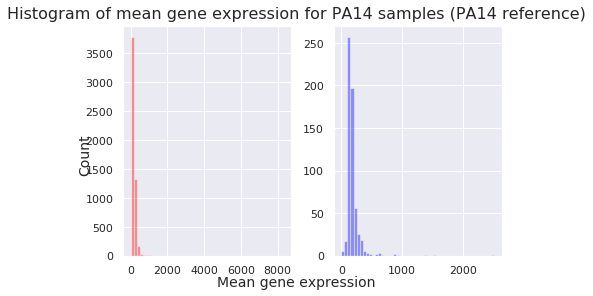

In [33]:
# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

# Distribution plot for core genes
sns.distplot(pa14_samples_pa14_ref_core.values, 
             label='PA14 samples PA14 core genes', 
             color='red',
             kde=False,
             ax=axes[0]
            )

sns.distplot(pa14_samples_pa14_ref_acc.values,
             label='PA14 samples PA14 accessory genes',
             color='blue',
             kde=False,
             ax=axes[1]
            )

fig.xlim=(0,10)
plt.suptitle('Histogram of mean gene expression for PA14 samples (PA14 reference)',
            fontsize=16)
fig.text(0.5, 0.01, 'Mean gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)
plt.tight_layout(pad=0.4, 
                 w_pad=0.5,
                 h_pad=1.0,
                 rect=[0, 0.03, 1, 0.95])

## Calculate correlation
Within PAO1 samples:
* **corr**(PAO1 core, PAO1 core)
* **corr**(PAO1 core, PAO1 accessory)
* **corr**(PAO1 accessory, PAO1 accessory) 

Within PA14 samples:
* **corr**(PA14 core, PA14 core)
* **corr**(PA14 core, PA14 accessory)
* **corr**(PA14 accessory, PA14 accessory)

In [15]:
# Get correlation of core-core genes
pao1_core_corr = data_core_pao1_samples_pao1_ref.corr(method='pearson')
pao1_core_corr = pao1_core_corr.values[np.triu_indices(n=len(pao1_core_corr), k=1)]

pa14_core_corr = data_core_pa14_samples_pa14_ref.corr(method='pearson')
pa14_core_corr = pa14_core_corr.values[np.triu_indices(n=len(pa14_core_corr), k=1)]

pa14_samples_pao1_core_corr = data_core_pa14_samples_pao1_ref.corr(method='pearson')
pa14_samples_pao1_core_corr = pa14_samples_pao1_core_corr.values[
    np.triu_indices(n=len(pa14_samples_pao1_core_corr), k=1)]

pao1_samples_pa14_core_corr = data_core_pao1_samples_pa14_ref.corr(method='pearson')
pao1_samples_pa14_core_corr = pao1_samples_pa14_core_corr.values[
    np.triu_indices(n=len(pao1_samples_pa14_core_corr), k=1)]

In [16]:
# Get correlation of accessory-accessory genes
pao1_acc_corr = data_acc_pao1_samples_pao1_ref.corr(method='pearson')
pao1_acc_corr = pao1_acc_corr.values[np.triu_indices(n=len(pao1_acc_corr), k=1)]

pa14_acc_corr = data_acc_pa14_samples_pa14_ref.corr(method='pearson')
pa14_acc_corr = pa14_acc_corr.values[np.triu_indices(n=len(pa14_acc_corr), k=1)]

pa14_samples_pao1_acc_corr = data_acc_pa14_samples_pao1_ref.corr(method='pearson')
pa14_samples_pao1_acc_corr = pa14_samples_pao1_acc_corr.values[
    np.triu_indices(n=len(pa14_samples_pao1_acc_corr), k=1)]

pao1_samples_pa14_acc_corr = data_acc_pao1_samples_pa14_ref.corr(method='pearson')
pao1_samples_pa14_acc_corr = pao1_samples_pa14_acc_corr.values[
    np.triu_indices(n=len(pao1_samples_pa14_acc_corr), k=1)]

In [17]:
# Get correlation of all genes
pao1_all_corr = gene_expression_ref_pao1.loc[pao1_ids].corr(method='pearson')
pa14_all_corr = gene_expression_ref_pa14.loc[pa14_ids].corr(method='pearson')

pao1_core_acc_corr = pao1_all_corr.loc[core_pao1_genes, pao1_acc]
pao1_core_acc_corr = pao1_core_acc_corr.values.flatten().tolist()

pa14_core_acc_corr = pa14_all_corr.loc[core_pa14_genes, pa14_acc]
pa14_core_acc_corr = pa14_core_acc_corr.values.flatten().tolist()

pa14_samples_pao1_all_corr = gene_expression_ref_pao1.loc[pa14_ids].corr(method='pearson')
pa14_samples_pao1_core_acc_corr = pa14_samples_pao1_all_corr.loc[core_pao1_genes, pao1_acc]
pa14_samples_pao1_core_acc_corr = pa14_samples_pao1_core_acc_corr.values.flatten().tolist()

pao1_samples_pa14_all_corr = gene_expression_ref_pa14.loc[pao1_ids].corr(method='pearson')
pao1_samples_pa14_core_acc_corr = pao1_samples_pa14_all_corr.loc[core_pa14_genes, pa14_acc]
pao1_samples_pa14_core_acc_corr = pao1_samples_pa14_core_acc_corr.values.flatten().tolist()

In [18]:
# Get correlation of control dataset
shuffled_pao1_ref_pao1_corr = shuffled_all_ref_pao1.loc[pao1_ids].corr(method='pearson')
shuffled_pao1_ref_pao1_corr = shuffled_pao1_ref_pao1_corr.values[
    np.triu_indices(n=len(shuffled_pao1_ref_pao1_corr), k=1)]

shuffled_pa14_ref_pa14_corr = shuffled_all_ref_pa14.loc[pa14_ids].corr(method='pearson')
shuffled_pa14_ref_pa14_corr = shuffled_pa14_ref_pa14_corr.values[
    np.triu_indices(n=len(shuffled_pa14_ref_pa14_corr), k=1)]

shuffled_pa14_ref_pao1_corr = shuffled_all_ref_pao1.loc[pa14_ids].corr(method='pearson')
shuffled_pa14_ref_pao1_corr = shuffled_pa14_ref_pao1_corr.values[
    np.triu_indices(n=len(shuffled_pa14_ref_pao1_corr), k=1)]

shuffled_pao1_ref_pa14_corr = shuffled_all_ref_pa14.loc[pao1_ids].corr(method='pearson')
shuffled_pao1_ref_pa14_corr = shuffled_pao1_ref_pa14_corr.values[
    np.triu_indices(n=len(shuffled_pao1_ref_pa14_corr), k=1)]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Density')

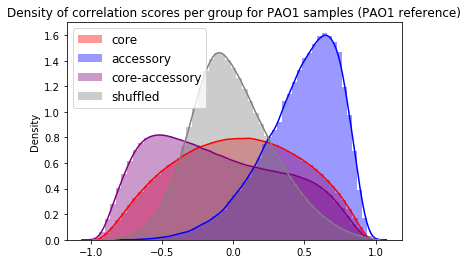

In [19]:
sns.distplot(pao1_core_corr, label='core', color='red')
sns.distplot(pao1_acc_corr, label='accessory', color='blue')
sns.distplot(pao1_core_acc_corr, label='core-accessory', color='purple')
sns.distplot(shuffled_pao1_ref_pao1_corr, label='shuffled', color='grey')

plt.legend(prop={'size': 12})
plt.title('Density of correlation scores per group for PAO1 samples (PAO1 reference)')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

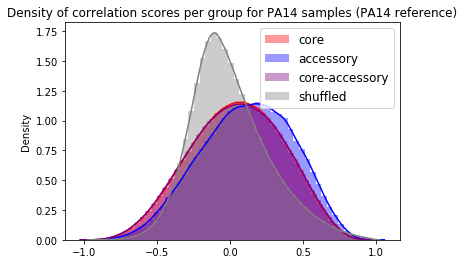

In [20]:
sns.distplot(pa14_core_corr, label='core', color='red')
sns.distplot(pa14_acc_corr, label='accessory', color='blue')
sns.distplot(pa14_core_acc_corr, label='core-accessory', color='purple')
sns.distplot(shuffled_pa14_ref_pa14_corr, label='shuffled', color='grey')

plt.legend(prop={'size': 12})
plt.title('Density of correlation scores per group for PA14 samples (PA14 reference)')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

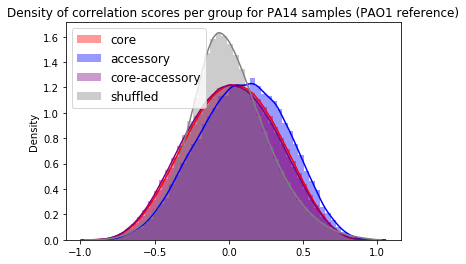

In [21]:
sns.distplot(pa14_samples_pao1_core_corr, label='core', color='red')
sns.distplot(pa14_samples_pao1_acc_corr, label='accessory', color='blue')
sns.distplot(pa14_samples_pao1_core_acc_corr, label='core-accessory', color='purple')
sns.distplot(shuffled_pa14_ref_pao1_corr, label='shuffled', color='grey')

plt.legend(prop={'size': 12})
plt.title('Density of correlation scores per group for PA14 samples (PAO1 reference)')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

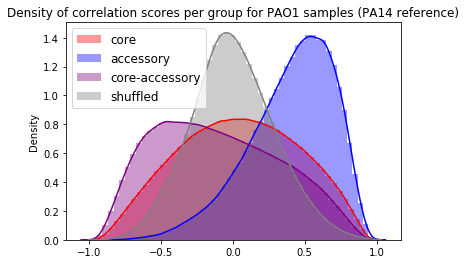

In [22]:
sns.distplot(pao1_samples_pa14_core_corr, label='core', color='red')
sns.distplot(pao1_samples_pa14_acc_corr, label='accessory', color='blue')
sns.distplot(pao1_samples_pa14_core_acc_corr, label='core-accessory', color='purple')
sns.distplot(shuffled_pao1_ref_pa14_corr, label='shuffled', color='grey')

plt.legend(prop={'size': 12})
plt.title('Density of correlation scores per group for PAO1 samples (PA14 reference)')
plt.ylabel('Density')

**Takeaway:**